#Importing packages and fixing WD

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

#For Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Changing WD
os.chdir('/content/drive/MyDrive/Colab/Vault/Projects/Credit_Card_Fraud/')

#Reading data from source

In [3]:
%time
org_data=pd.read_csv('Data/creditcardfraud.zip',compression='zip')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [4]:
org_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
org_data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#Preliminary analysis functions

In [7]:
class prelim_desc:
    def __init__(self,dataset,columns=None,plot=False,maxn=10):
        self.dataset = dataset
        self.ccolumns=columns
        self.plot=plot
        self.maxn=maxn
        data=dataset.copy()
        dtypes=pd.DataFrame(data.dtypes.value_counts(),columns=["count"])
        print("No total columns    : ",data.shape[1])
        print("No total observation: ",data.shape[0],"\n")
        print(dtypes,"\n")
        if columns != None:
            data=data.iloc[:,columns]
        self.data=data
        d_unique = data.nunique().to_dict()
        out_unique = pd.DataFrame.from_dict({k:d_unique[k] for k in d_unique if d_unique[k] <= maxn},orient='index').reset_index(level=0)
        out_unique.columns=["feature","count"]
        out_unique_sorted=out_unique.sort_values("count")
        self.out_unique=out_unique

        if plot == True:
            import matplotlib.pyplot as plt
            import seaborn as sns
            sns.set_theme(style="darkgrid")
            plt.figure(figsize = (16,len(out_unique)/4))
            ax = sns.barplot(y="feature",x="count",data=out_unique_sorted).set(title="No of Unique Values < "+str(maxn))
        #Empty columns/ columns containg all cells empty
        self.empty_columns = out_unique["feature"][out_unique["count"]==0]
        print("Empty columns: ",self.empty_columns.tolist(),"\n")
        #Missing count and %
        col_with_missing = data.isnull().sum()[data.isnull().sum()!=0]
        col_with_missing = pd.DataFrame(col_with_missing,columns=["count"])
        col_with_missing["percentage"] = (col_with_missing["count"]/data.shape[0])*100
        self.col_with_missing=col_with_missing
        #univariate
        stat=data.describe([.01,.05,.25,.50,.75,.90,.95,.99])
        stat=stat.transpose()
        stat['% of zero']=((dataset.select_dtypes([np.number]) == 0).sum(axis=0)/len(dataset))*100
        stat['% of missing']=((dataset.select_dtypes([np.number]).isna()== 1).sum(axis=0)/len(dataset))*100
        stat['range']=stat['75%']-stat['25%']
        self.stat=stat[['count', '% of missing', '% of zero', 'std', 'min', '1%', '5%', '25%', '50%', 'mean', '75%', '90%',
               '95%', '99%', 'max','range']].round(2)
        
    def nuniques(self,var=None):
        if var==None:
            return(self.out_unique)
        else:
            return(self.stat.loc[var])

    def stats(self,var=None):
        if var==None:
            return(self.stat)
        else:
            return(self.stat.loc[var])
        
    def missing(self,var=None):
        if var==None:
            return(self.col_with_missing)
        else:
            return(self.col_with_missing.loc[var])
        
    def zero(self,var=None):
        if var==None:
            return(self.stat["% of zero"])
        else:
            return(self.stat["% of zero"].loc[var])
        
    def empty_columns(self,):
        return(self.empty_columns)
    
    def count_plot(self,var=None,figsize = (12,5),theme="darkgrid"):
        import matplotlib.pyplot as plt
        import seaborn as sns
        if var==None:
            for col in self.data.columns:
                plt.figure(figsize = figsize)
                sns.set_theme(style=theme)
                ax = sns.countplot(x=col, data=self.data).set(title="Countplot of "+str(col)+" (Total obs:"+str(len(self.data))+")")
        else:
            for col in var:
                sns.set_theme(style=theme)
                plt.figure(figsize = figsize)
                ax = sns.countplot(x=col, data=self.data).set(title="Countplot of "+str(col)+" (Total obs:"+str(len(self.data))+")")
                
    def hist_plot(self,var=None,figsize = (12,5),theme="darkgrid",bins="auto"):
        import matplotlib.pyplot as plt
        import seaborn as sns
        if var==None:
            for col in self.data.columns:
                plt.figure(figsize = figsize)
                sns.set_theme(style=theme)
                ax = sns.histplot(x=col, data=self.data,bins=bins).set(title="Histogram of "+str(col)+" (Total obs:"+str(len(self.data))+")")
        else:
            for col in var:
                sns.set_theme(style=theme)
                plt.figure(figsize = figsize)
                ax = sns.histplot(x=col, data=self.data,bins=bins).set(title="Histogram of "+str(col)+" (Total obs:"+str(len(self.data))+")")
        

#Descriptive statistics

No total columns    :  31
No total observation:  284807 

         count
float64     30
int64        1 

Empty columns:  [] 



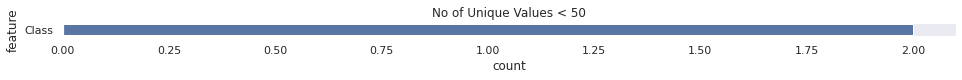

In [8]:
desc=prelim_desc(org_data,columns=None,maxn=50,plot=True)

Class is only variable with categorical values.
All other variables are continuous.

In [9]:
desc.nuniques()

,feature,count
0,Class,2


In [10]:
desc.zero()

Time       0.00
V1         0.00
V2         0.00
V3         0.00
V4         0.00
V5         0.00
V6         0.00
V7         0.00
V8         0.00
V9         0.00
V10        0.00
V11        0.00
V12        0.00
V13        0.00
V14        0.00
V15        0.00
V16        0.00
V17        0.00
V18        0.00
V19        0.00
V20        0.00
V21        0.00
V22        0.00
V23        0.00
V24        0.00
V25        0.00
V26        0.00
V27        0.00
V28        0.00
Amount     0.64
Class     99.83
Name: % of zero, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

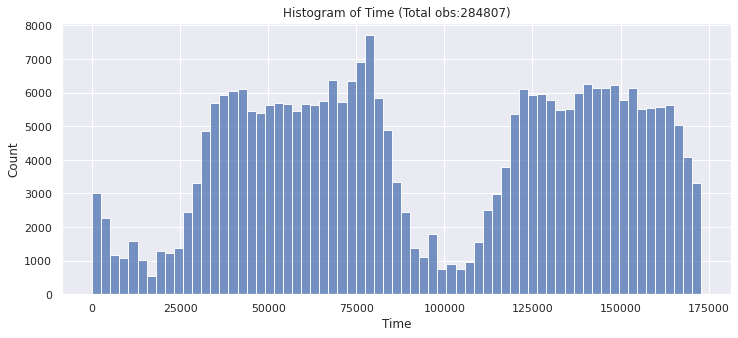

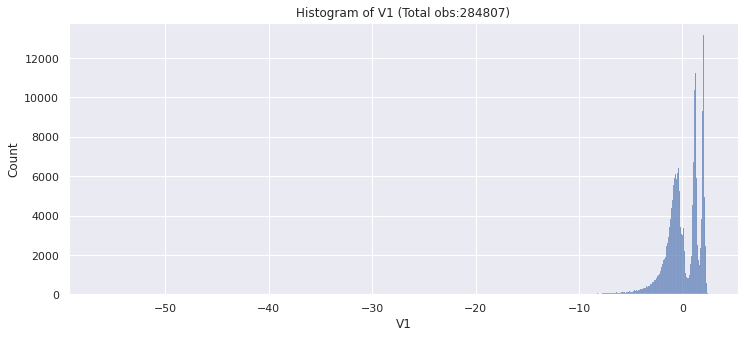

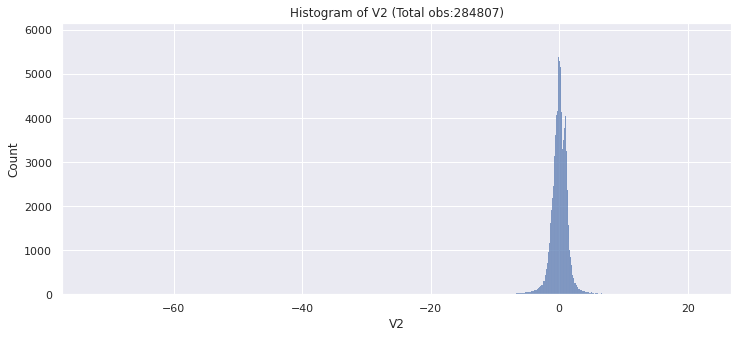

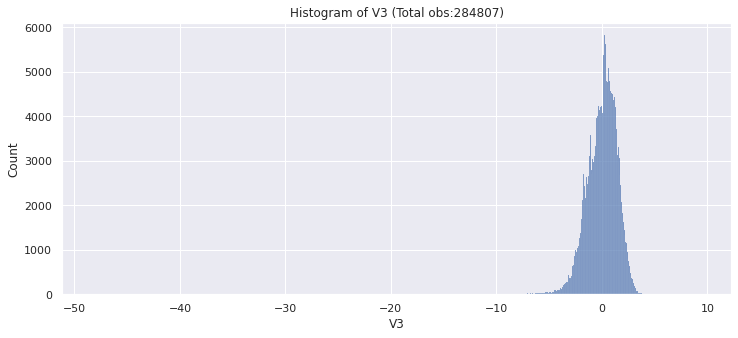

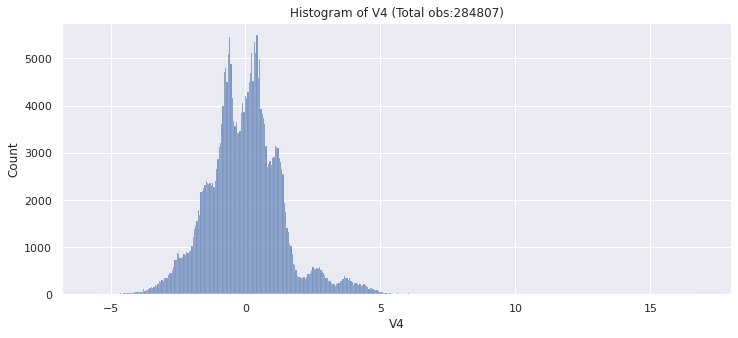

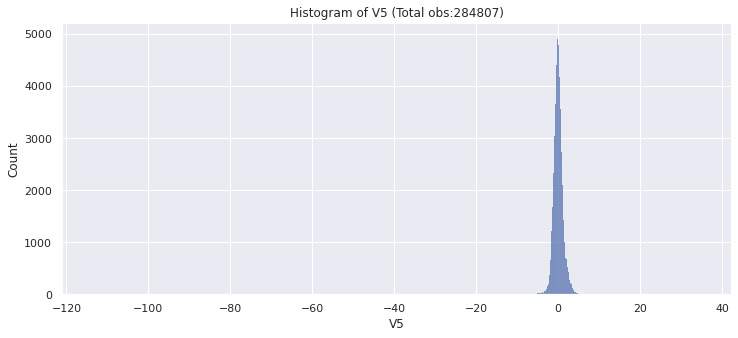

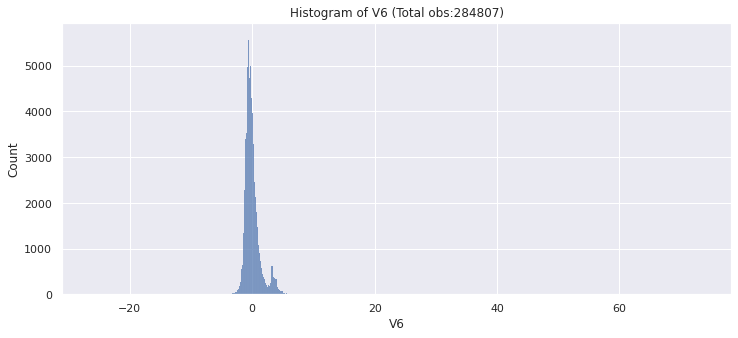

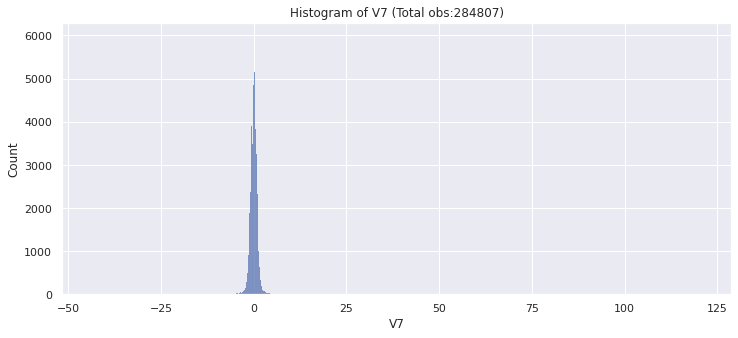

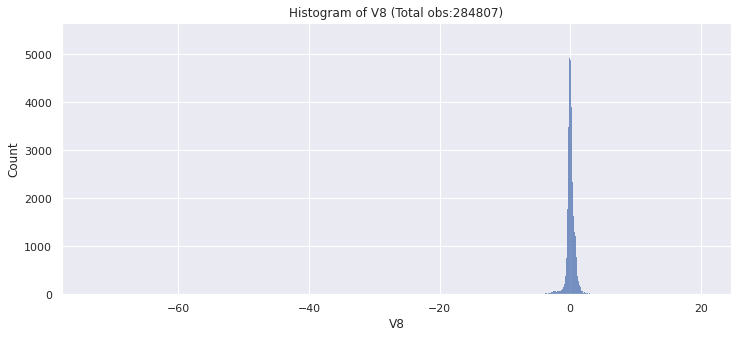

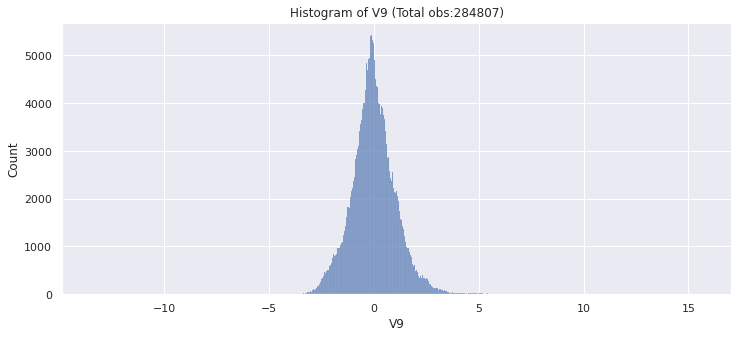

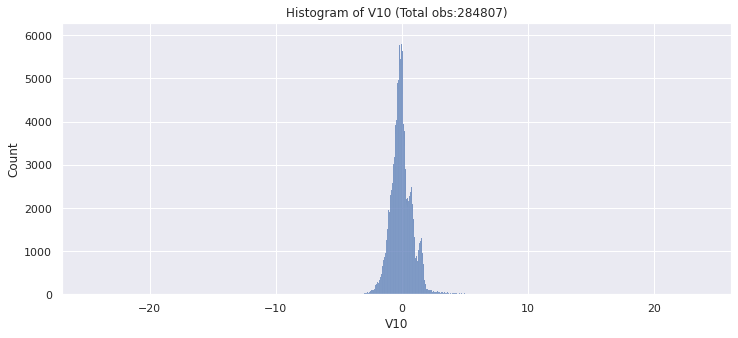

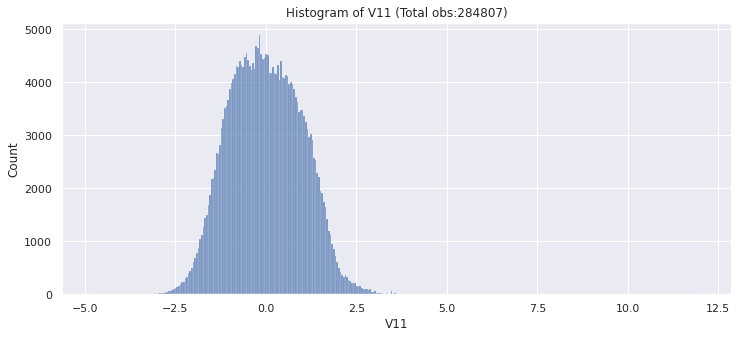

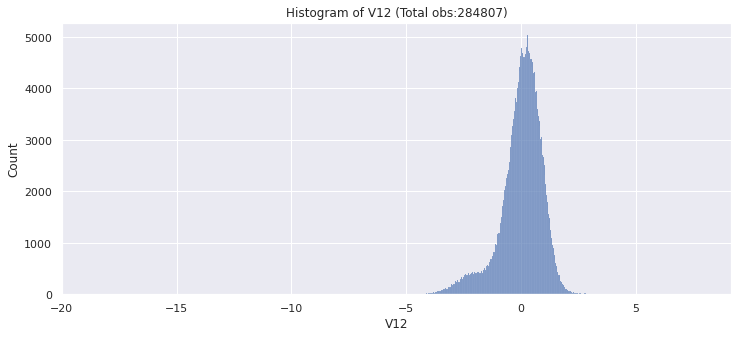

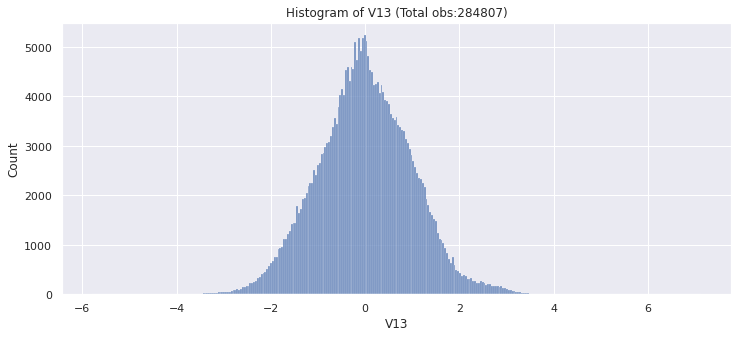

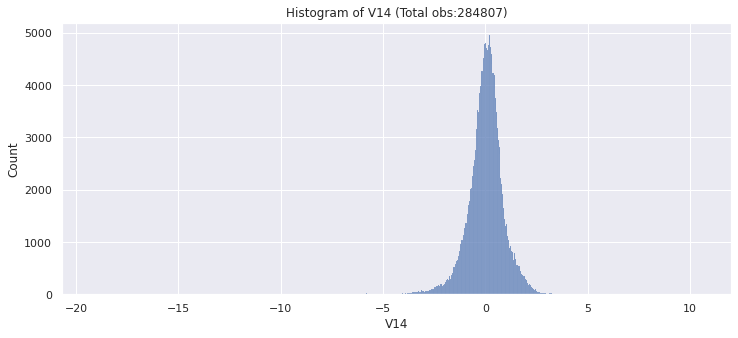

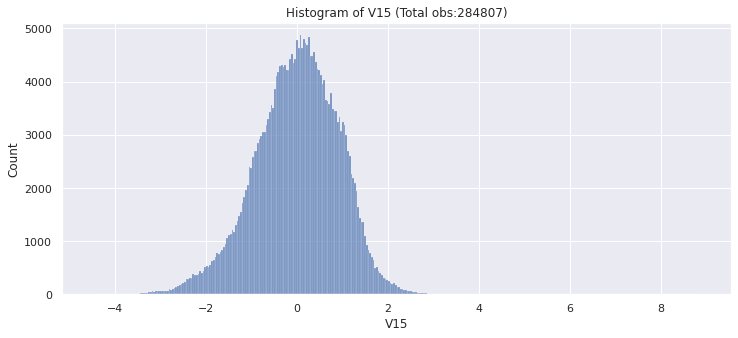

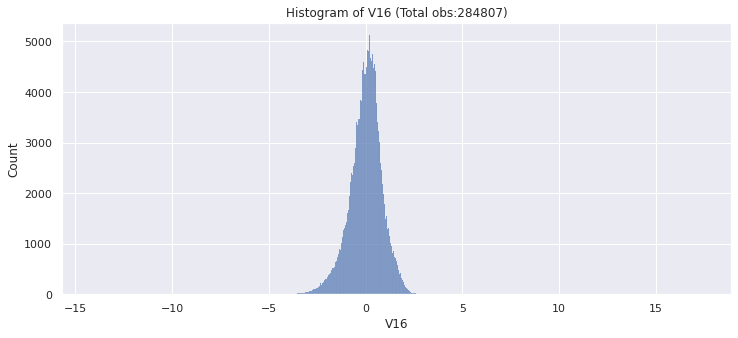

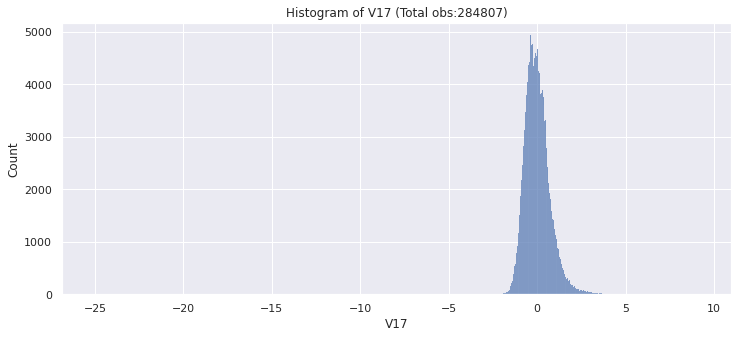

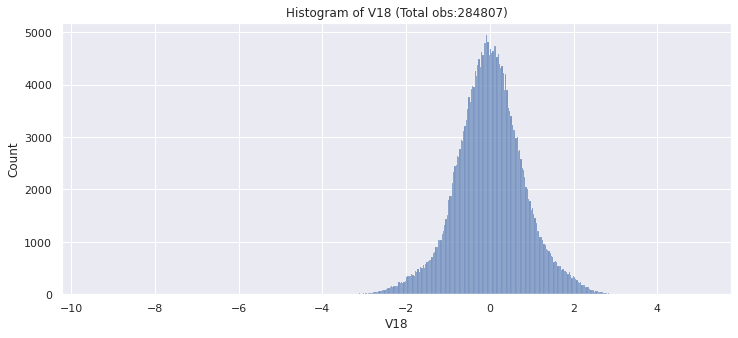

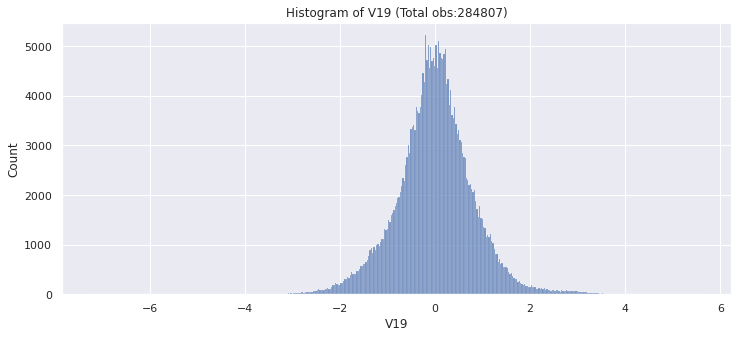

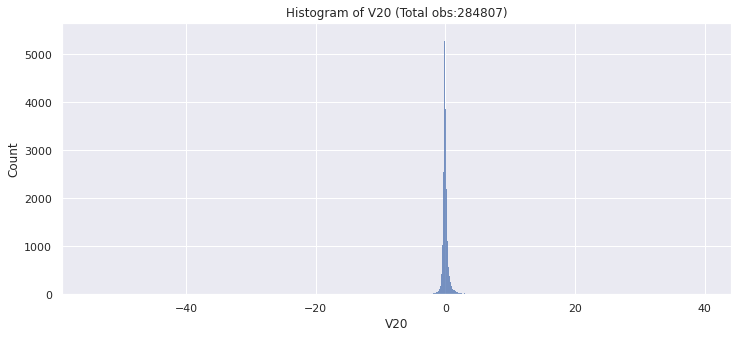

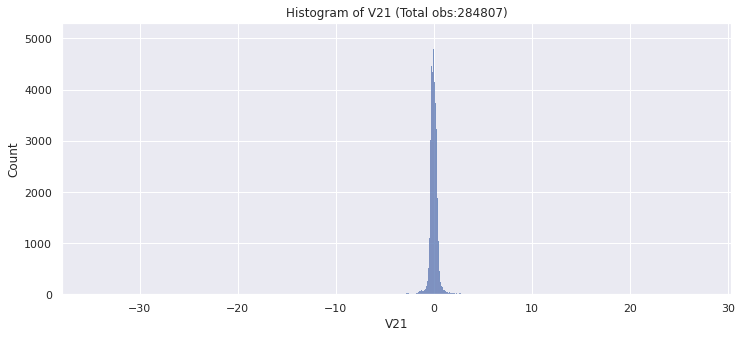

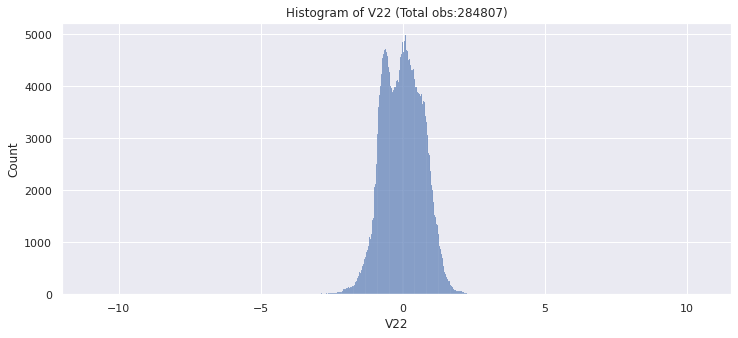

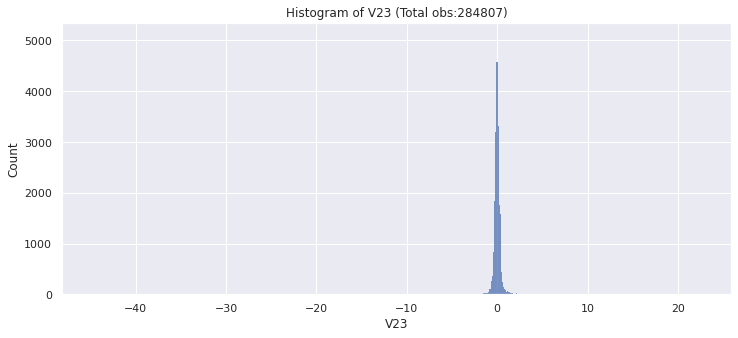

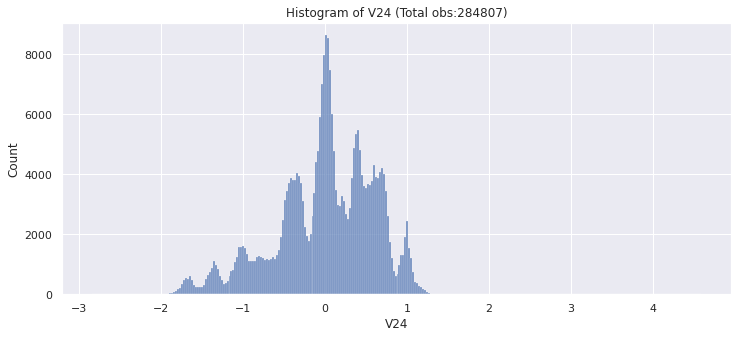

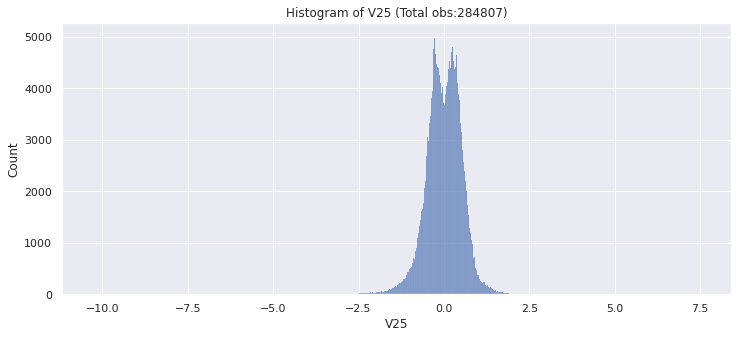

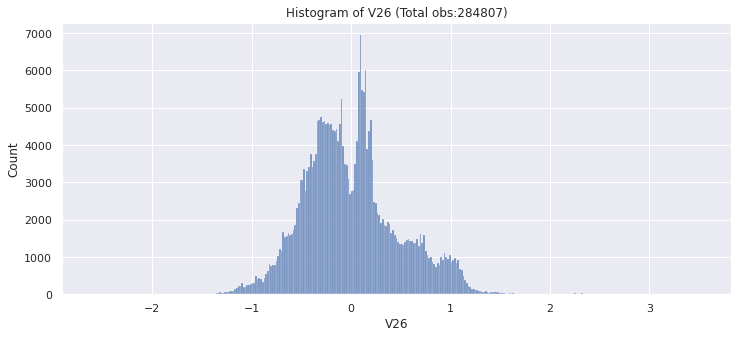

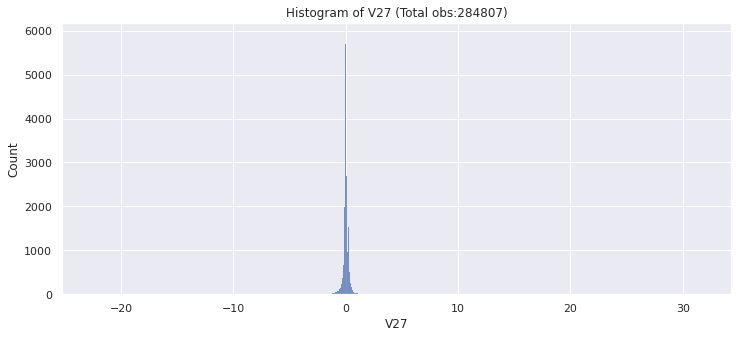

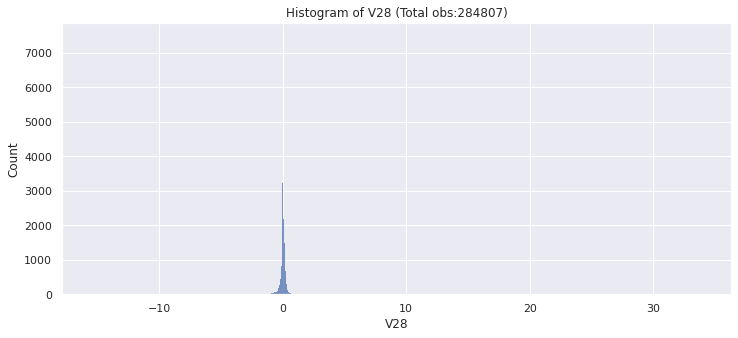

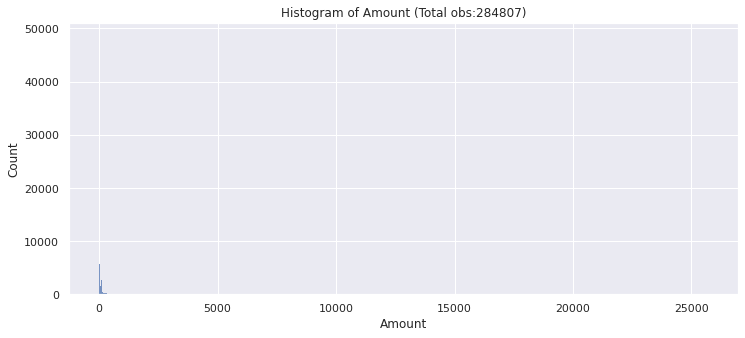

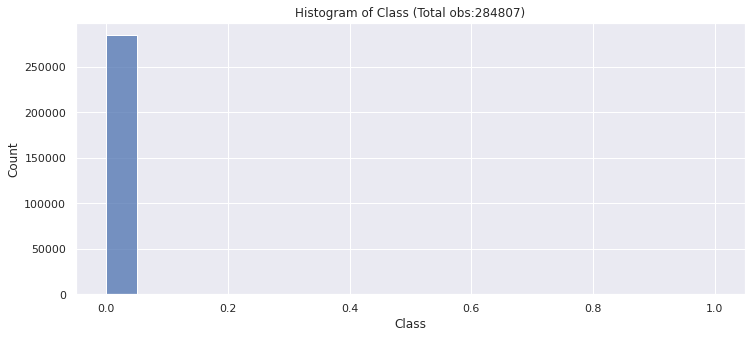

In [11]:
desc.hist_plot()

In [12]:
desc.stats()

,count,% of missing,% of zero,std,min,1%,5%,25%,50%,mean,75%,90%,95%,99%,max,range
Time,284807.0,0.0,0.00,47488.15,0.00,2422.00,25297.60,54201.50,84692.00,94813.86,139320.50,157640.40,164143.40,170560.94,172792.00,85119.00
V1,284807.0,0.0,0.00,1.96,-56.41,-6.56,-2.90,-0.92,0.02,0.00,1.32,2.02,2.08,2.24,2.45,2.24
V2,284807.0,0.0,0.00,1.65,-72.72,-4.96,-1.97,-0.60,0.07,0.00,0.80,1.33,1.81,3.80,22.06,1.40
V3,284807.0,0.0,0.00,1.52,-48.33,-3.98,-2.39,-0.89,0.18,-0.00,1.03,1.68,2.06,2.73,9.38,1.92
V4,284807.0,0.0,0.00,1.42,-5.68,-3.12,-2.20,-0.85,-0.02,0.00,0.74,1.48,2.57,4.25,16.88,1.59
V5,284807.0,0.0,0.00,1.38,-113.74,-3.06,-1.70,-0.69,-0.05,0.00,0.61,1.41,2.10,3.42,34.80,1.30
V6,284807.0,0.0,0.00,1.33,-26.16,-2.12,-1.41,-0.77,-0.27,0.00,0.40,1.51,3.16,4.20,73.30,1.17
V7,284807.0,0.0,0.00,1.24,-43.56,-3.01,-1.43,-0.55,0.04,-0.00,0.57,1.04,1.41,2.70,120.59,1.12
V8,284807.0,0.0,0.00,1.19,-73.22,-4.03,-0.84,-0.21,0.02,0.00,0.33,0.77,1.05,2.08,20.01,0.54
V9,284807.0,0.0,0.00,1.10,-13.43,-2.46,-1.76,-0.64,-0.05,-0.00,0.60,1.30,1.78,2.99,15.59,1.24


In [13]:
desc.missing()

,count,percentage


In [14]:
desc.empty_columns

Series([], Name: feature, dtype: object)

No missing value in the dataset.

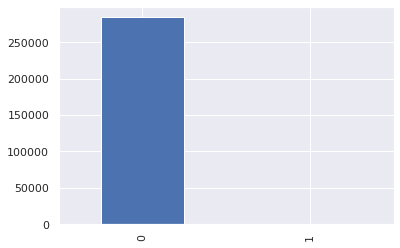

In [15]:
org_data.Class.value_counts().plot.bar()

In [16]:
org_data.Class.value_counts()/org_data.Class.value_counts().sum()*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

**Summary**:


1.   There is no missing values in the dataset.
2.   Time to Amount will be independent feature and Class will be the dependent feature.

3.   Time and Amount isnot scalled and other independent features were gone through PCA. Assuming that V features are already scalled.
4.   Most of the transactions were Non-Fraud (99.83% to be precise). Only 0.17% of total transactions are Fraud.





#Preprocessing: Scalling

In [17]:
mod_data = org_data.copy()

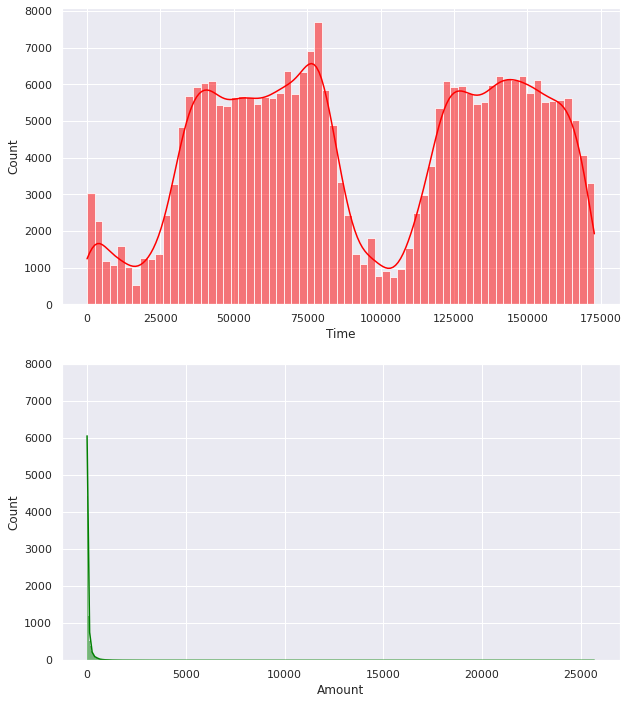

In [18]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2, 1, figsize=(10,12))
sns.histplot(data=org_data,x="Time",ax=ax[0],label="Time distribution",kde=True,color="red")
sns.histplot(data=org_data,x="Amount",ax=ax[1],label="Amount distribution",kde=True,color="green")
ax[1].set_ylim([0,8000])
plt.show()

In [19]:
stan_scaler = StandardScaler()
rob_scaler = RobustScaler()
mod_data['Amount'] = rob_scaler.fit_transform(mod_data['Amount'].values.reshape(-1,1))
mod_data['Time'] = rob_scaler.fit_transform(mod_data['Time'].values.reshape(-1,1))


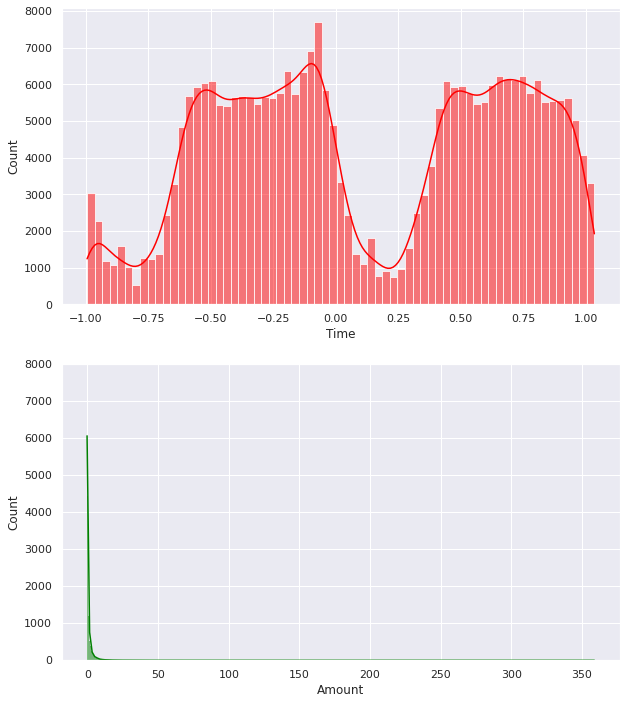

In [20]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2, 1, figsize=(10,12))
sns.histplot(data=mod_data,x="Time",ax=ax[0],label="Time distribution after scale",kde=True,color="red")
sns.histplot(data=mod_data,x="Amount",ax=ax[1],label="Amount distribution after scale",kde=True,color="green")
ax[1].set_ylim([0,8000])
plt.show()

**Dsecriptive stats after scaling**

In [21]:
desc_mod=prelim_desc(mod_data)

No total columns    :  31
No total observation:  284807 

         count
float64     30
int64        1 

Empty columns:  [] 



In [22]:
desc_mod.stats(["Time","Amount"])

,count,% of missing,% of zero,std,min,1%,5%,25%,50%,mean,75%,90%,95%,99%,max,range
Time,284807.0,0.0,0.00,0.56,-0.99,-0.97,-0.70,-0.36,0.0,0.12,0.64,0.86,0.93,1.01,1.04,1.0
Amount,284807.0,0.0,0.13,3.50,-0.31,-0.31,-0.29,-0.23,0.0,0.93,0.77,2.53,4.79,13.92,358.68,1.0


In [23]:
#Before scaling
desc.stats(["Time","Amount"])

,count,% of missing,% of zero,std,min,1%,5%,25%,50%,mean,75%,90%,95%,99%,max,range
Time,284807.0,0.0,0.00,47488.15,0.0,2422.00,25297.60,54201.5,84692.0,94813.86,139320.50,157640.4,164143.4,170560.94,172792.00,85119.00
Amount,284807.0,0.0,0.64,250.12,0.0,0.12,0.92,5.6,22.0,88.35,77.16,203.0,365.0,1017.97,25691.16,71.56


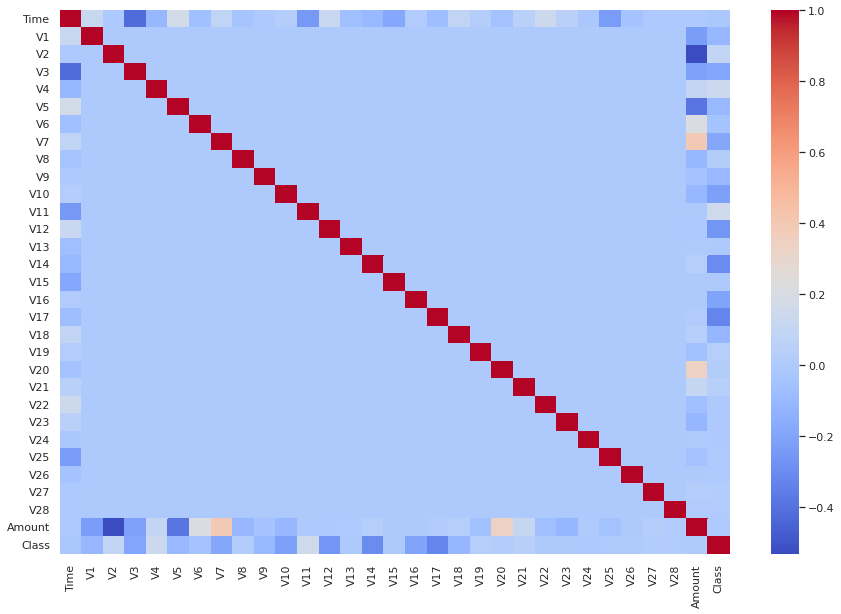

In [24]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(mod_data.corr(),cmap="coolwarm")

In [25]:
mod_data.corr()[mod_data.corr()<-.5]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.531409,NaN
V3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
V9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observed high correlation between Amount and V2. But since its not very high i.e. 0.531, will ignore that. 

#SubSampling

In [26]:
sample1 = mod_data.sample(frac=1)
sample_fraud = sample1[sample1.Class==1]
sample_nonfraud = sample1[sample1.Class==0].iloc[:len(sample_fraud)]
sample = pd.concat([sample_fraud,sample_nonfraud])
sample = sample.sample(frac=1, random_state=0)

In [27]:
sample.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

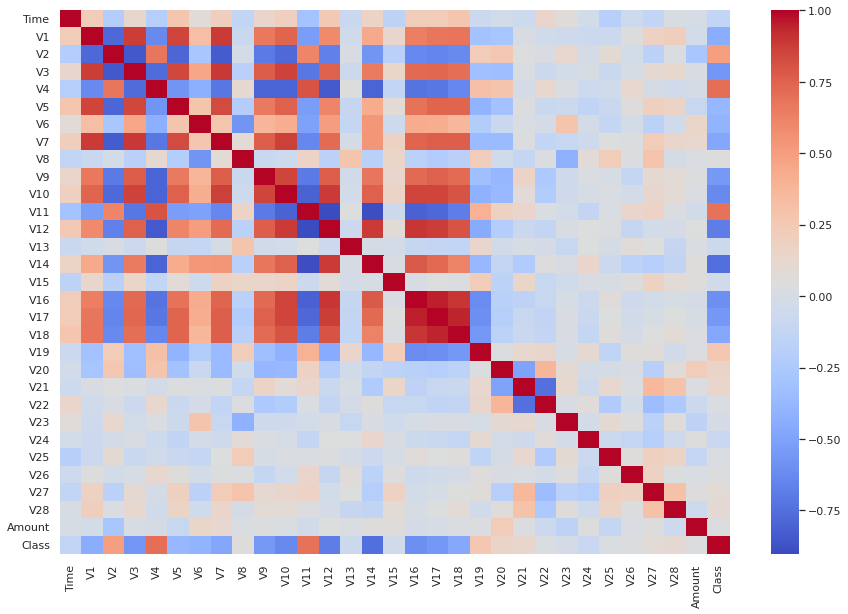

In [28]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(sample.corr(),cmap="coolwarm")

In [29]:
sample.corr().unstack()["Class"][sample.corr().unstack()["Class"]<-.2].sort_values()

V14   -0.748963
V12   -0.685322
V10   -0.626555
V16   -0.598241
V3    -0.563948
V17   -0.558949
V9    -0.552656
V7    -0.474138
V18   -0.469346
V1    -0.437074
V6    -0.399768
V5    -0.373040
dtype: float64

In [30]:
sample.corr().unstack()["Class"][sample.corr().unstack()["Class"]>.2].sort_values()

V19      0.268112
V2       0.499829
V11      0.692442
V4       0.706381
Class    1.000000
dtype: float64

In [31]:
def filtered_cor_pair(data: pd.DataFrame, tol: float):
    data_cor = data.corr()
    data_cor_filtered = data_cor[((data_cor >= tol) | (data_cor <= -tol)) & (data_cor !=1.000)]
    out_data = data_cor_filtered.unstack().drop_duplicates().dropna()
    return out_data

# a=" "
# for i in filtered_cor_pair(sample, .87)[filtered_cor_pair(sample, .85)<0].index:
#   a=a+", "+str(i).replace(r"'","")
# a

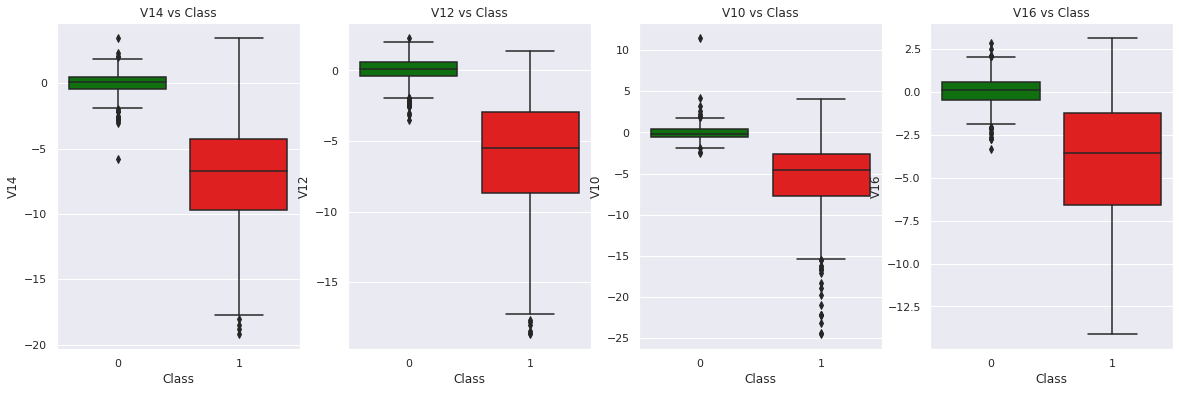

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(20,6))

colors = ["green","red"]
sns.boxplot(x="Class", y="V14", data=sample, palette=colors, ax=axes[0])
axes[0].set_title("V14 vs Class")
sns.boxplot(x="Class", y="V12", data=sample, palette=colors, ax=axes[1])
axes[1].set_title("V12 vs Class")
sns.boxplot(x="Class", y="V10", data=sample, palette=colors, ax=axes[2])
axes[2].set_title("V10 vs Class")
sns.boxplot(x="Class", y="V16", data=sample, palette=colors, ax=axes[3])
axes[3].set_title("V16 vs Class")
plt.show()

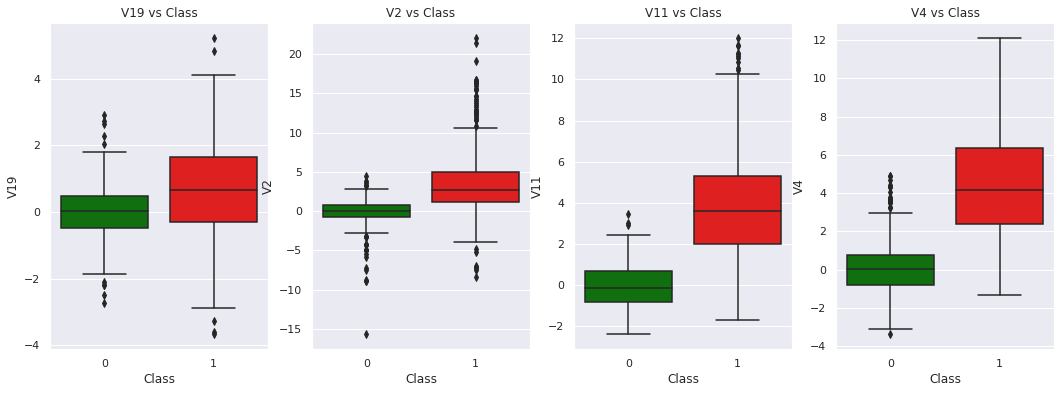

In [33]:
f, axes = plt.subplots(ncols=4, figsize=(18,6))

colors = ["green","red"]
sns.boxplot(x="Class", y="V19", data=sample, palette=colors, ax=axes[0])
axes[0].set_title('V19 vs Class')
sns.boxplot(x="Class", y="V2", data=sample, palette=colors, ax=axes[1])
axes[1].set_title('V2 vs Class')
sns.boxplot(x="Class", y="V11", data=sample, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class')
sns.boxplot(x="Class", y="V4", data=sample, palette=colors, ax=axes[3])
axes[3].set_title('V4 vs Class')

plt.show()

 
**Summary :**
*   V14, V12, V10, V16 are highly negatively correlated with Class.
More lower these values are, the more likely the class will be a fraud.
*  V19, V2, V11, V4 are positively correlated with Class.
More higher these values are, the more likely the class will be a fraud.


#Data preparation for model fitting

In [34]:
#Undersample dataset will be used
X = sample.drop("Class", axis=1)
y = sample["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:

#Logistic Regression 
GSCV_logistic = GridSearchCV(LogisticRegression(),
                             {"penalty": ["l1", "l2"],
                              "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]})
GSCV_logistic.fit(X_train.values, y_train.values)

final_logistic= GSCV_logistic.best_estimator_


#KNN
GSCV_knn = GridSearchCV(KNeighborsClassifier(),
                        {"n_neighbors": list(range(2,5,1)),
                         "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]})
GSCV_knn.fit(X_train.values, y_train.values)

final_knn = GSCV_knn.best_estimator_

#Support Vector Classifier
GSCV_svc = GridSearchCV(SVC(), 
                        {"C": [0.5, 0.7, 0.9, 1],
                         "kernel": ["rbf", "poly", "sigmoid", "linear"]})
GSCV_svc.fit(X_train.values, y_train.values)

final_svc = GSCV_svc.best_estimator_

# DecisionTree
GSCV_dtree = GridSearchCV(DecisionTreeClassifier(),
                         {"criterion": ["gini", "entropy"],
                          "max_depth": list(range(2,4,1)),
                          "min_samples_leaf": list(range(5,7,1))})
GSCV_dtree.fit(X_train.values, y_train.values)

final_dtree = GSCV_dtree.best_estimator_


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [36]:
print("\n Logistic Regression Classification report: \n",classification_report(y_test.values, final_logistic.predict(X_test.values)))
print("\n K Nearest Neighbor Classification report: \n",classification_report(y_test.values, final_knn.predict(X_test.values)))
print("\n Support Vector Classification report: \n",classification_report(y_test.values, final_svc.predict(X_test.values)))
print("\n Decision Tree Classification report: \n",classification_report(y_test.values, final_dtree.predict(X_test.values)))



 Logistic Regression Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       101
           1       0.93      0.90      0.91        96

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197


 K Nearest Neighbor Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       101
           1       0.98      0.90      0.93        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197


 Support Vector Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.94      0.91      0.92        96

    accuracy                           0.92    

In [37]:
#ROC Plot
print("\n Logistic Regression Classification report: \n",classification_report(y_test.values, final_logistic.predict(X_test.values)))
print("\n K Nearest Neighbor Classification report: \n",classification_report(y_test.values, final_knn.predict(X_test.values)))
print("\n Support Vector Classification report: \n",classification_report(y_test.values, final_svc.predict(X_test.values)))
print("\n Decision Tree Classification report: \n",classification_report(y_test.values, final_dtree.predict(X_test.values)))


log_fpr, log_tpr, log_thresold = roc_curve(y_test.values, final_logistic.predict(X_test.values))
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_test, final_knn.predict(X_test.values))
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, final_svc.predict(X_test.values))
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, final_dtree.predict(X_test.values))


 Logistic Regression Classification report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       101
           1       0.93      0.90      0.91        96

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197


 K Nearest Neighbor Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       101
           1       0.98      0.90      0.93        96

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197


 Support Vector Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       101
           1       0.94      0.91      0.92        96

    accuracy                           0.92    

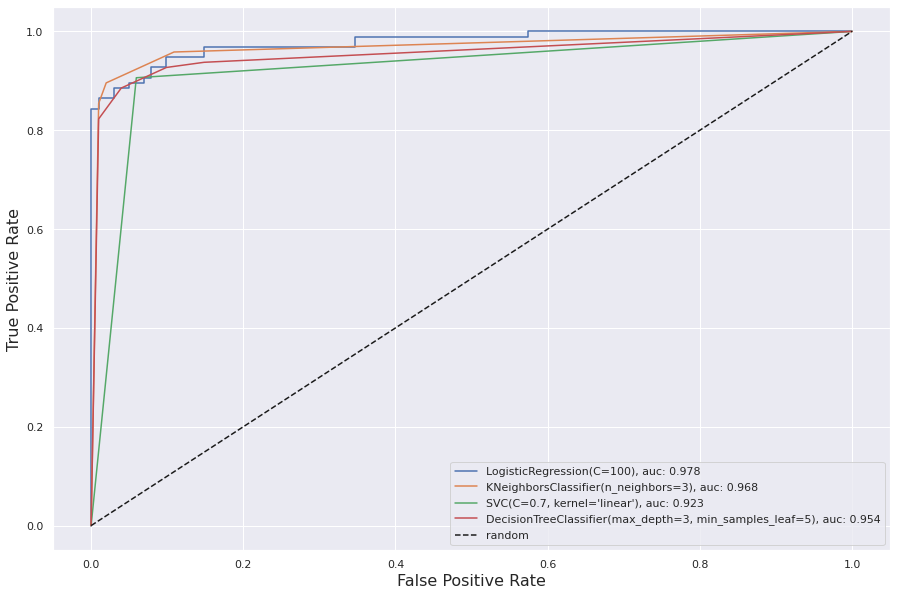

In [38]:
#ROC Curve
for curves in [final_logistic,final_knn,final_svc,final_dtree]:
  try:
    log_fpr, log_tpr, log_thresold = roc_curve(y_test.values, curves.predict_proba(X_test.values)[:, 1])
    auc=round(roc_auc_score(y_test.values, curves.predict_proba(X_test.values)[:, 1]),3)
  except:
    log_fpr, log_tpr, log_thresold = roc_curve(y_test.values, curves.predict(X_test.values))
    auc=round(roc_auc_score(y_test.values, curves.predict(X_test.values)),3)
  plt.plot(log_fpr, log_tpr,label=str(curves)+", auc: "+str(auc))
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.plot([0, 1], [0, 1], 'k--', label="random")
plt.legend()
plt.show()

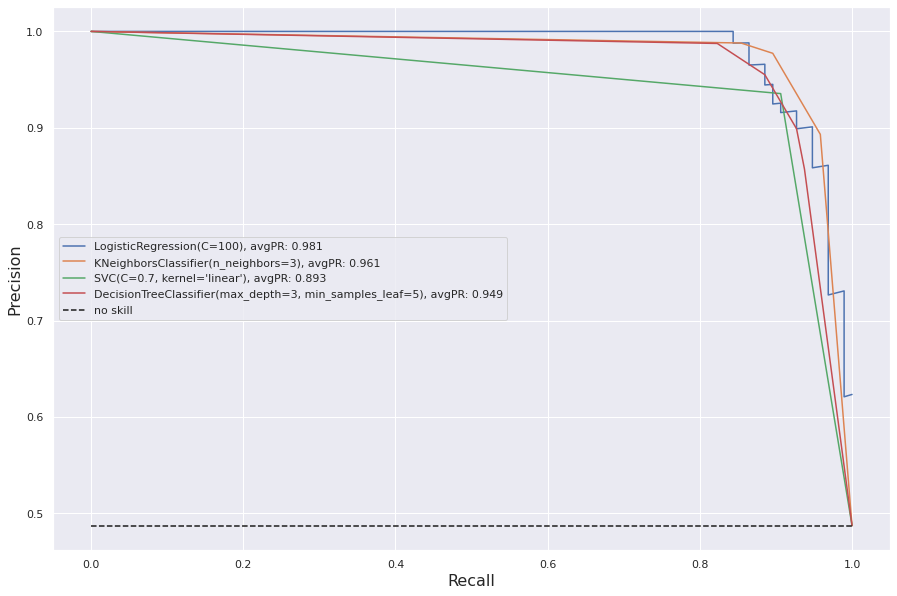

In [39]:
#Precision - Recall Curve
for curves in [final_logistic,final_knn,final_svc,final_dtree]:
  try:
    precision, recall, threshold = precision_recall_curve(y_test.values, curves.predict_proba(X_test.values)[:, 1])
    apr=round(average_precision_score(y_test.values, curves.predict_proba(X_test.values)[:, 1]),3)
  except:
    precision, recall, threshold = precision_recall_curve(y_test.values, curves.predict(X_test.values))
    apr=round(average_precision_score(y_test.values, curves.predict(X_test.values)),3)
  plt.plot(recall, precision, label=str(curves)+", avgPR: "+str(apr))
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
ns=len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1],[ns,ns],'k--', label="no skill")
plt.legend()
plt.show()